# **Team A 🚲 Bike Sharing Analysis**
![Image](https://storage.googleapis.com/gweb-uniblog-publish-prod/original_images/image1_hH9B4gs.jpg)

#### Maria Aguilera, Friederike Botermann, Angel Intriago, Catherine Sierra 
#### Chala Getu, Luis Miguel Victoria, Siyu Wu


# **Table of Contents**

* [1. Introduction](#1)
  * [1.1 Task Description](#1.1)
  * [1.2 Variable Definitions](#1.2) 
  * [1.3 Set up environment](#1.3)
  * [1.4 Loading data](#1.4)

* [2. Exploratory Data Analysis ](#2)
  * [2.1 Null Vlaue](#2.1)
  * [2.2 Data Inconsistency](#2.2)
  * [2.3 Outlier](#2.3)
  * [2.4 Correlation](#2.4)
* [3. Data Engineering ](#3)
  * [3.1 Generation Extra Features related to date](#3.1)
  * [3.2 Create categorical feature from continous feature](#3.2)
  * [ 3.3 Create log features- windspeed](#3.3)
  * [3.4 Pipeline-Time-Based cross validation](#3.4)
  * [3.5 Deal with Missing Value & outlier](#3.5)
* [4. Machine Learning (predictive analytics) ](#4)
  * [4.1 Baseline Model(Linear Regression)](#4.1)
  * [4.2 Random Forest Regressor](#4.2)
  * [4.3 Decision Tree](#4.3)
  * [4.4 Grid Search best Parameters](#4.4)
      * [4.4.1 Pipeline 1](#4.4.1)
      * [4.4.2 Pipeline 2](#4.4.2)
      * [4.4.3 Pipeline 3](#4.4.3)
  * [4.5 Plot the prediction and Actual Value](#4.5)
 



Note: With 💡 emoji would contain our insights


<a id='1'></a>
# 1. Introduction

<a id='1.1'></a>
### **🚲1.1 Task Description**
**Goal**: predict the total number of Washington D.C. bicycle users on an hourly basis.
* **Training data**: whole 2011 and first 3 quarters of 2012.
* **Test data**: 4th quarter of 2012. Do not use it to fit your models!
* **Target**: total number of users (cnt)
* **Error metric**: R2 score (scikit-learn's default for regression).
* **Features to use:** at least the ones present in the data (except for `cnt`, `casual`, and `registered`).

<a id='1.2'></a>
### **🚲1.2 Variable Definitions**
- **instant**: record index
- **dteday** : date
- **hr** : hour (0 to 23)
- **weathersit** : Weather situation
- **temp** : Normalized temperature in Celsius. The values are divided to 41 (max)
- **atemp**: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- **hum**: Normalized humidity. The values are divided to 100 (max)
- **windspeed**: Normalized wind speed. The values are divided to 67 (max)
- **casual**: count of casual users
- **registered**: count of registered users
- **cnt**: count of total rental bikes including both casual and registered

<a id='1.3'></a>
### **🚲1.3 Set up Environment**


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Bike Sharing Prediction

/content/drive/MyDrive/Bike Sharing Prediction


In [4]:
import sklearn
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.impute import KNNImputer, SimpleImputer
sns.set()

<a id='1.4'></a>
### 🚲**1.4 Loading data**

In [5]:
df = pd.read_csv("hour.csv",index_col='instant',parse_dates=['dteday'],dayfirst=True)

In [6]:
df.head()

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1


<a id='2'></a>
# 2. Explanatory Data Analysis
* Ensuring data quality (correctness, consistency, missing values, outliers...).
* Plotting clear and meaningful figures.
* Giving insights on what seems relevant for prediction and what does not.
* Bonus points for:
    * Checking possibly redundant variables via correlations.

In [ ]:
df.dtypes #check the variable types

dteday        datetime64[ns]
hr                     int64
weathersit            object
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [ ]:
# Check how many unique values each column has
df.nunique()

dteday        731
hr             24
weathersit      4
temp           50
atemp          65
hum            89
windspeed      30
casual        322
registered    776
cnt           869
dtype: int64

💡**From this we can say `weathersit` and `hr` are categorical variables**
 > we will try to use `hr` as categoricla variable

In [ ]:
# checking for monotonicity
# monotonic is defined as either a non-increasing or non-decreasing set of ordered values
print(df.index.is_monotonic_increasing)
print(df.index.is_unique)

True
True


<a id='2.1'></a>
## **🚲 2.1 Check for Null Value**

In [ ]:
df.isna().sum()

dteday          0
hr              0
weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
casual          0
registered      0
cnt             0
dtype: int64

💡 Five columns such as `weathersit`,`temp`,`atemp`,`hum`,and `windspeed` contains null values

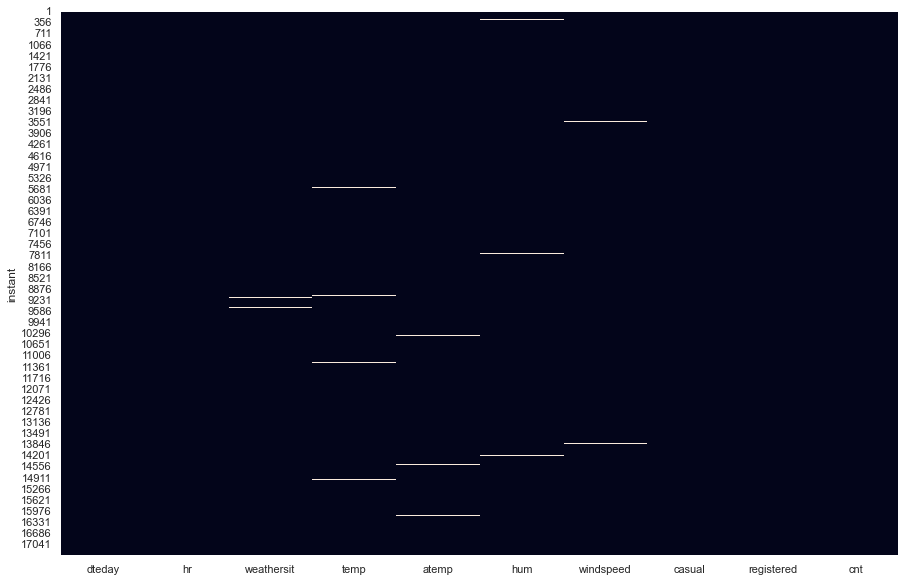

In [ ]:
##see the distribution of our null values
plt.figure(figsize=(15,10))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

<a id='2.2'></a>
## 🚲 2.2 Check for Inconsistency

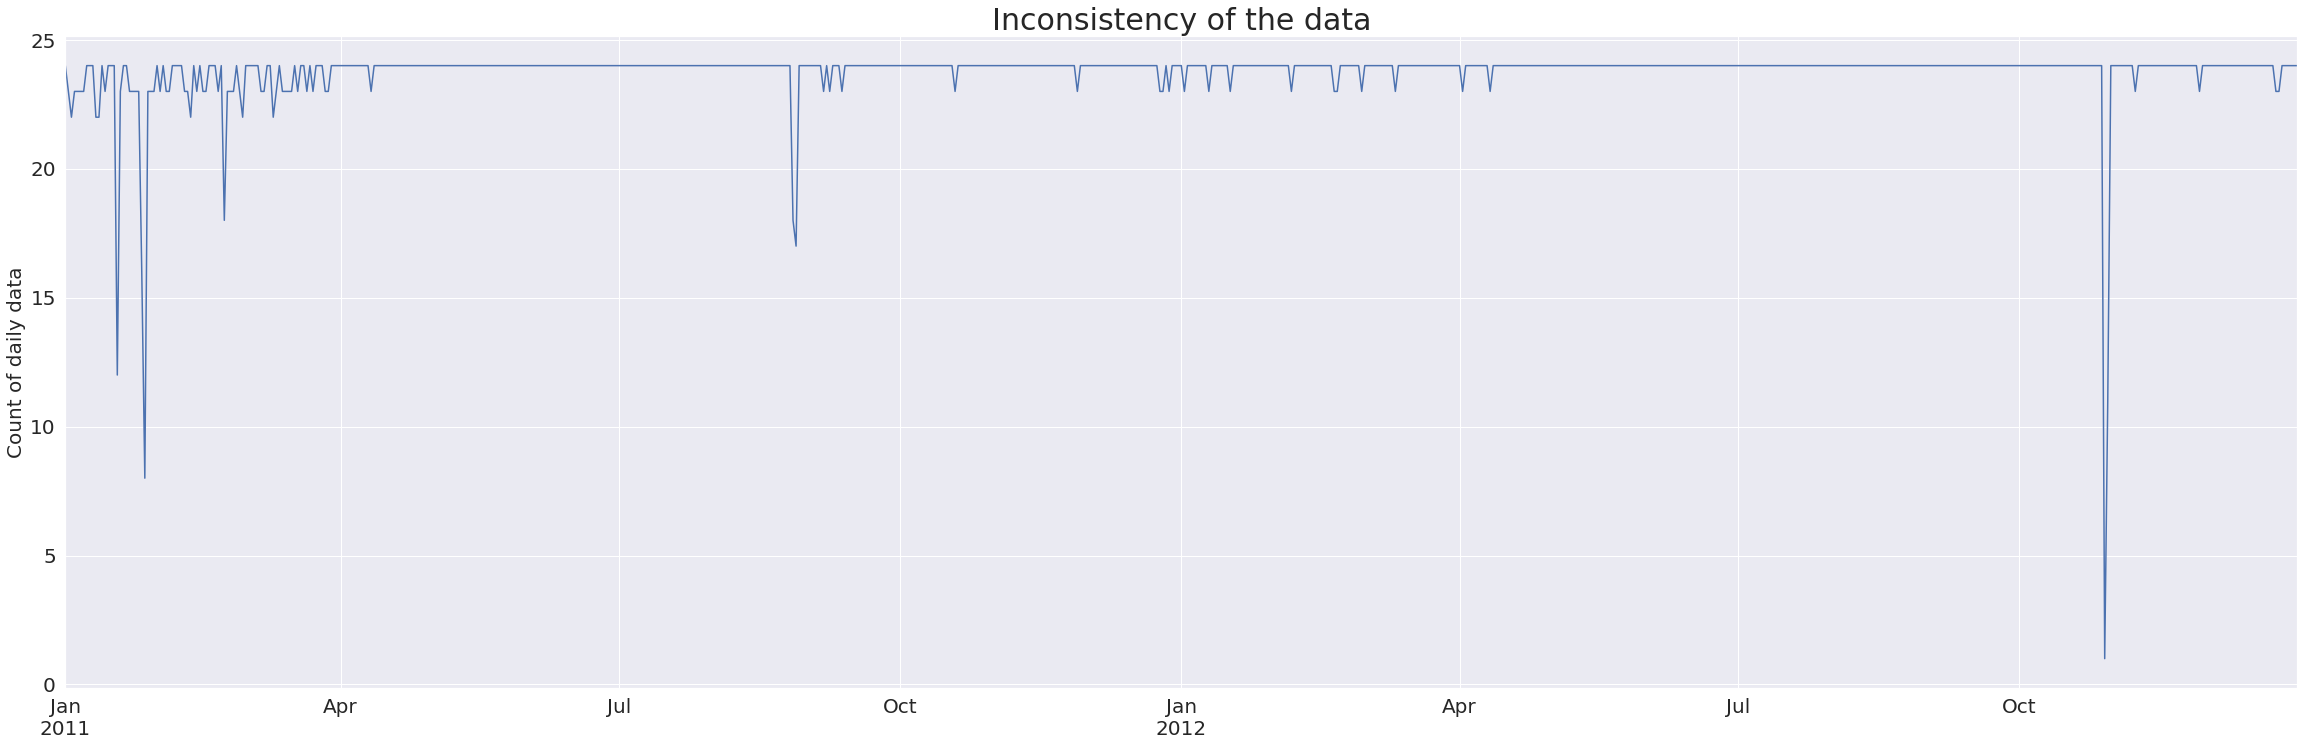

In [9]:
gf = df.dteday.value_counts().sort_index().plot(figsize=(40,12))
gf.set_title("Inconsistency of the data",fontsize= 30)
gf.set_ylabel('Count of daily data',fontsize=20)
gf.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('Inconsistency of Data.png')

#### 💡 **From the chart, We witness a significant dip in October 2012. There is a day when the business was not operating for 23 hours.**


In [11]:
df_in = df.groupby('dteday').count()

In [12]:
incosistent_dates = list(df_in.loc[df_in['cnt']<10].index)

In [13]:
df.loc[df['dteday'].isin(incosistent_dates)]

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
588,2011-01-27,16,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2273,0.55,0.1940,1,23,24
589,2011-01-27,17,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2424,0.55,0.1045,2,82,84
590,2011-01-27,18,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.20,0.2273,0.69,0.0896,3,101,104
591,2011-01-27,19,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.20,0.2273,0.69,0.0896,3,76,79
592,2011-01-27,20,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.18,0.2121,0.74,0.0896,4,55,59
593,2011-01-27,21,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.18,0.2121,0.74,0.0896,2,36,38
594,2011-01-27,22,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.18,0.2121,0.74,0.0896,0,27,27
595,2011-01-27,23,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.18,0.1970,0.80,0.1642,0,16,16
15884,2012-10-29,0,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.44,0.4394,0.88,0.3582,2,20,22


💡 Since dealing with inconsistency requires some domain knowledge we tried to research a little bit more about those dates. 
>
So we found that:
* On Jan 27 2011, a major winter storm according to https://en.wikipedia.org/wiki/January_25–27,_2011_North_American_blizzard#Washington,_D.C.
* on October 10 2012,  a hurricane Sandy in Washington DC according to https://en.wikipedia.org/wiki/Hurricane_Sandy

So it can be inferred that these missing hours are due to some underlying cause and hence cannot be imputed.


In [ ]:
# check for duplicates
df.duplicated().sum()

0

<a id='2.3'></a>
## 🚲 2.3 Check for Outlier 

In [ ]:
df.describe()

,hr,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17280.000000,17279.000000,17279.000000,17279.000000,17379.000000,17379.000000,17379.000000
mean,11.546752,0.497071,0.475530,0.627235,0.190114,35.676218,153.786869,189.463088
std,6.914405,0.192474,0.171782,0.193047,0.122378,49.305030,151.357286,181.387599
min,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,12.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,18.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,23.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


##### **Plot histogram to see the distribution of our numerical dataset**

### Numerical Column Skewness checking
> For normally distributed data (temp, atmep, windspead and hum), the skewness should be close to 0. 
>
> if skewness >0, it would have more weight in right tail

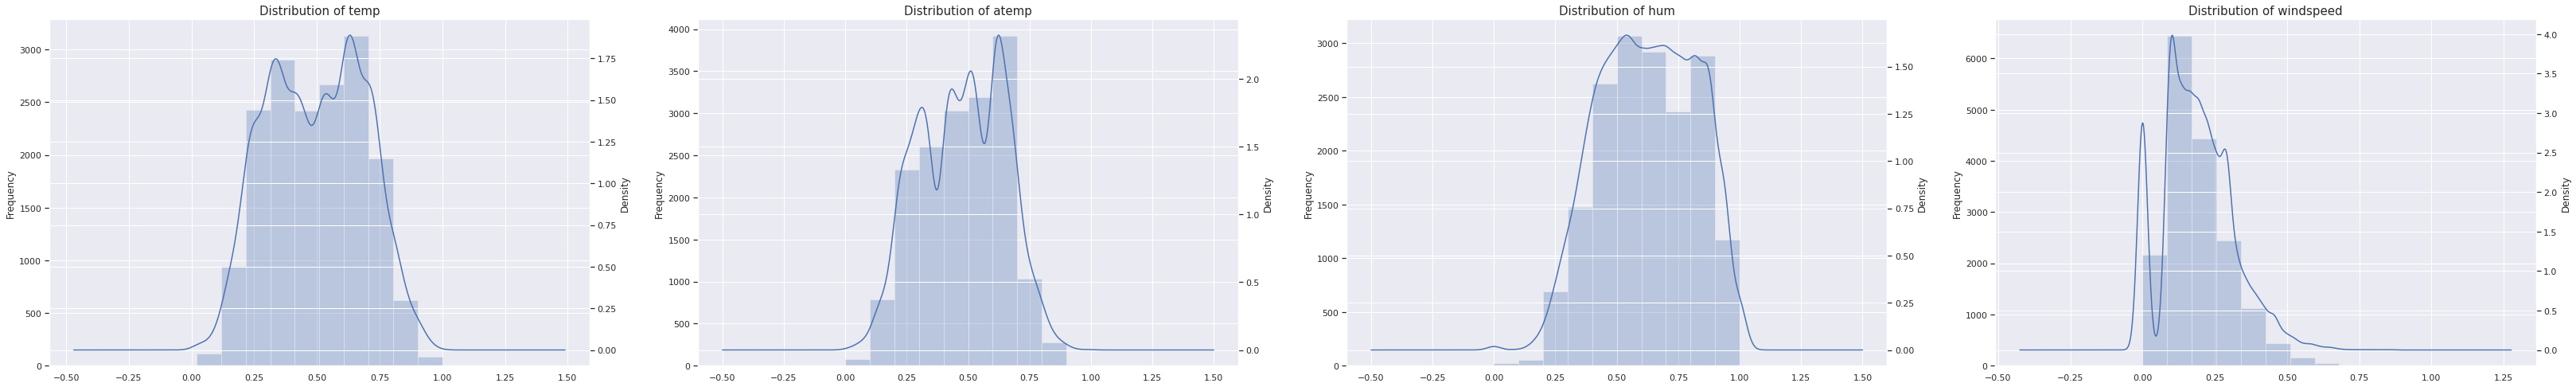

In [15]:
numerical_columns = ['temp', 'atemp', 'hum','windspeed']

fig, ax = plt.subplots(ncols=4, figsize = (56, 8))

for i, axes in enumerate(ax.ravel()):
    # histogram and kernel density estimation function of numerical variables
    df[numerical_columns[i]].plot.hist(ax=axes,alpha=0.3)
    axes_kde = axes.twinx()
    df[numerical_columns[i]].plot.kde(ax=axes_kde)
    axes.set_title(f'Distribution of {numerical_columns[i]}', fontsize=15)
  
plt.savefig('Numerical Skewness.png')

In [16]:
temp = round(df["temp"].skew(),5)
print ("the skew of temp is", temp) 
atemp = round(df["atemp"].skew(),5)
print ("the skew of atemp is", atemp)
hum = round(df["hum"].skew(),5)
print ("the skew of hum is", hum) 
windspeed = round(df["windspeed"].skew(),5)
print ("the skew of windspeed is", windspeed) 

the skew of temp is -0.0055
the skew of atemp is -0.08999
the skew of hum is -0.11067
the skew of windspeed is 0.57726


> we can see the windspeed tend to skew more to right tail

### **Plot boxplot to see the distribution of our numerical dataset**

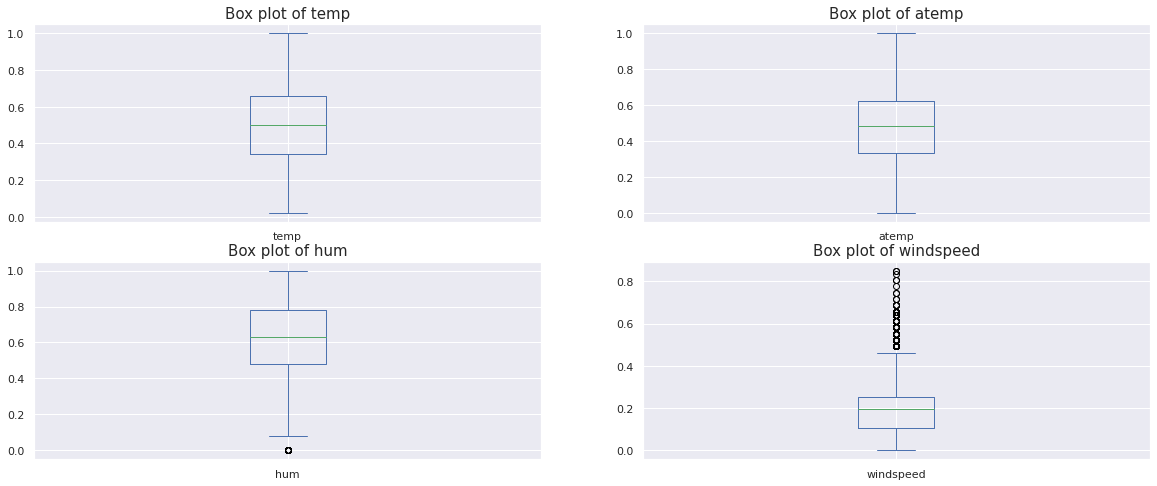

In [17]:
fig, ax = plt.subplots(2, 2, figsize = (20, 8))

for i, axes in enumerate(ax.ravel()):
    # box plot estimation function of the numerical values
    df[numerical_columns[i]].plot.box(ax=axes)
    axes.set_title(f'Box plot of {numerical_columns[i]}', fontsize=15)

## 💡From the above, `windspeed` have some skewed values, we will decide later on how to deal with it

In [18]:
df['weathersit'].value_counts()

Clear, Few clouds, Partly cloudy, Partly cloudy                                            11345
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                                4517
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds     1414
Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog                                     3
Name: weathersit, dtype: int64

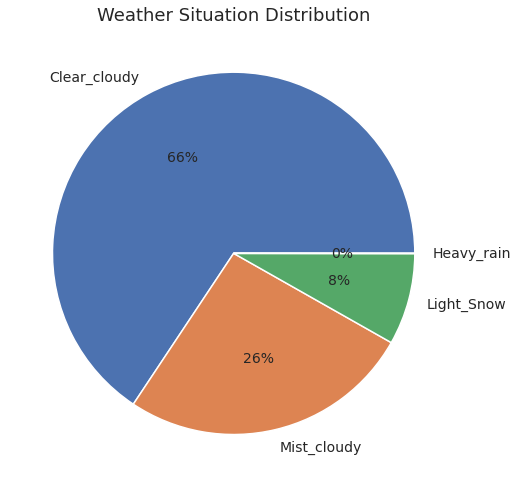

In [78]:
plt.figure(figsize=(10,7))
plt.pie(df['weathersit'].value_counts(),labels=['Clear_cloudy','Mist_cloudy','Light_Snow','Heavy_rain'],autopct='%1.0f%%',textprops={'fontsize': 14})
plt.title('Weather Situation Distribution',fontsize = 18)
plt.tight_layout()

plt.savefig('weather_distribution.png')
plt.show()

From above we can that `Clear,Few clouds, Partly cloudy, Partly cloudy` has high value.

<a id='2.4'></a>
## 🚲 2.4 Data Visualization

In [24]:
df.dtypes

dteday        datetime64[ns]
hr                     int64
weathersit            object
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [25]:
df.head()

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1


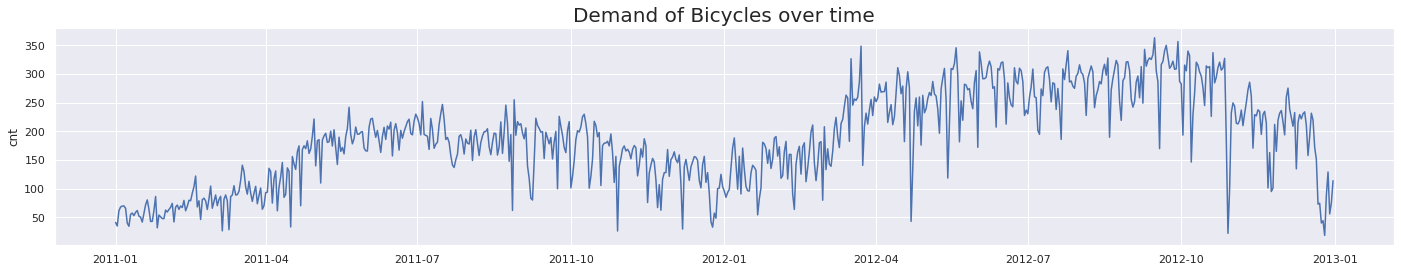

In [28]:
plt.figure(figsize = (24,4))
sns.lineplot(x='dteday',y = 'cnt',data = df,ci=None)
plt.title('Demand of Bicycles over time',fontsize=20)
plt.xlabel(None)
plt.savefig('over_time.png')


# 💡 Insight
* Year: According to the graph, 2012 seems has more rental than 2011
* Seasonality: Bike Rental seems to have a peak between May & October (warmer weather in U.S.)
> therefore, in data engineer part, we would like to extract feature related to season,month to see how it affect the count of rental bikes.

<a id='2.5'></a>
## 🚲 2.5 Corrleation

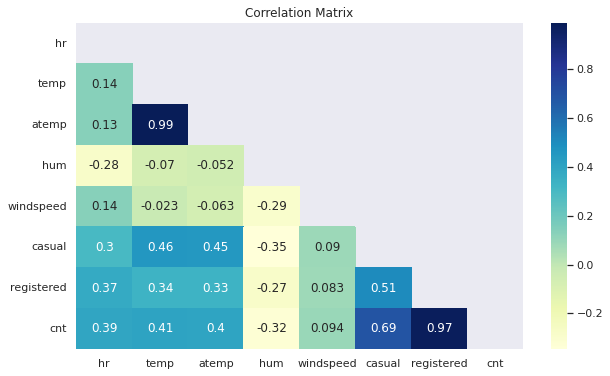

In [29]:
# Checking the correlation between the variables
plt.figure(figsize = (10,6))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu", mask=matrix)
plt.title("Correlation Matrix")
plt.show()

#### 💡 **From correlation corrlation matrix**
*  `temp` and `atemp` are highly correlated so we have to select one 
> Both variables are normalized, but seems that temp is perfectly distributed with a median value of 0.5 and the Skewness is closer to 0 (the skew of temp is -0.0055, the skew of atemp is -0.08999)
* `Registered` and `Casual` is related to `cnt` (data leakage), so we also not exclude feature set.

<a id='3'></a>
# 3. Data Engineering
* Discussion on missing values and outliers
* Treatment of text and date features
* Generation of extra features (e.g., season, yes/no holiday, hours of daylight, combinations of features, quantization/binarization, polynomial features)
* Use of scikit-learn pipelines to perform transformations

<a id='3.1'></a>
## 🚲 3.1 Generation Extra Features related to date


In [30]:
# 1.Season (1:Spring, 2:Summer, 3:Autumn, 4:Winter)

def season(mydate):
    # get the year from the date object
    year = mydate.year

    # create a list of seasons for comparison
    seasons = [
        (2, dt.date(year, 12, 21), dt.date(year, 12, 31)),
        (4, dt.date(year, 6, 21), dt.date(year, 9, 20)),
        (1, dt.date(year, 9, 21), dt.date(year, 12, 20)),
        (2, dt.date(year, 1, 1), dt.date(year, 3, 20)),
        (3, dt.date(year, 3, 21), dt.date(year, 6, 20)),
    ]

    # find the corresponding from the list and return it
    for season in seasons:
        if mydate >= season[1] and mydate <= season[2]:
            return season[0]

In [31]:
# 2. Since the data is related to Boston in U.S., we decided to used U.S. Holiday to define our holiday function

from pandas.tseries.holiday import USFederalHolidayCalendar
def get_holiday(date):
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start='2011'+'-01-01', end='2012'+'-12-31').strftime("%Y-%m-%d")
    holidays = list(holidays)
    holidays.extend(['2011-01-01','2011-12-25','2012-01-01','2012-11-11'])
    return np.where(date.isin(holidays), 1, 0)

In [32]:
df['season'] = df['dteday'].map(season)
df['month'] = df['dteday'].dt.month
df['year'] = df['dteday'].dt.year
df['weekday'] = df['dteday'].dt.weekday
# if it is weekday 1, if not 0
df['working_day'] = np.where(df['dteday'].dt.weekday < 5, 1, 0)

# office hour- define as 9 am -17 pm
df['office_hour'] = np.where((df['hr'] >= 9) & (df['hr'] < 17) & (df['dteday'].dt.weekday < 5), 1, 0)

# daytime - define as 6am till 22 pm
df['daytime'] = np.where((df['hr'] >= 6) & (df['hr'] < 22), 1, 0)

# rushhour morning - in week day if it is during 6 am- 10 am, define as rushhour morning
# rushhour evening - in week day if it is during 15 pm to 19pm define as rushhour evening
df['rushhour_morning'] = np.where((df['hr'] >= 6) & (df['hr'] < 10) & (df['dteday'].dt.weekday < 5), 1, 0)
df['rushhour_evening'] = np.where((df['hr'] >= 15) & (df['hr'] < 19) & (df['dteday'].dt.weekday < 5), 1, 0)

# high season - summer, if it is 1 is high season, if 0 is not 
df['highseason'] = np.where(df['dteday'].map(season) == 3, 1, 0) 

df['holiday'] = get_holiday(df['dteday'])

<ipython-input-30-3c7e4ad7598f>:18: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if mydate >= season[1] and mydate <= season[2]:


<a id='3.2'></a>
## 🚲 3.2 Create categorical feature from continous feature


In [33]:
def get_temp_bins(temp):
    # define bins
    bins = [-np.inf, 0.19, 0.49, 0.69, 0.89, np.inf]
    labels = ['low','low-medium','medium','medium-high','high']
    return pd.cut(temp, bins,labels=labels).cat.codes.to_frame()


In [34]:
def get_hum_bins(hum):
    # define bins
    bins = [-np.inf, 0.19, 0.49, 0.69, 0.89, np.inf]
    labels = ['low','low-medium','medium','medium-high','high']
    return pd.cut(hum, bins,labels=labels).cat.codes.to_frame()

In [35]:
df['temp_bin'] = get_temp_bins(df['temp'].fillna(method='ffill'))
df['hum_bin'] = get_hum_bins(df['hum'].fillna(method='ffill'))



<a id='3.3'></a>
## 🚲 3.3 Create log features- windspeed

* In previous part, we already find the `windspeed` has skewness issue and contains lots of outlier through the distribution

In [36]:
# we use log1p - Return the natural logarithm of one plus the input array
df['windspeed_log1p'] = np.log1p(df['windspeed'].fillna(method='ffill'))

windspeed_skew = round(df["windspeed"].skew(),5)

windspeedlog1p_skew = round(df["windspeed_log1p"].skew(),5)
print(windspeed_skew,windspeedlog1p_skew) # after log feature, the skewness is closer to 0

0.57726 0.26604


In [37]:
df.head(3)

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,...,working_day,office_hour,daytime,rushhour_morning,rushhour_evening,highseason,holiday,temp_bin,hum_bin,windspeed_log1p
instant,,,,,,,,,,,,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16,...,0,0,0,0,0,0,1,1,3,0.0
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40,...,0,0,0,0,0,0,1,1,3,0.0
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32,...,0,0,0,0,0,0,1,1,3,0.0



## Plot Correlation of Features

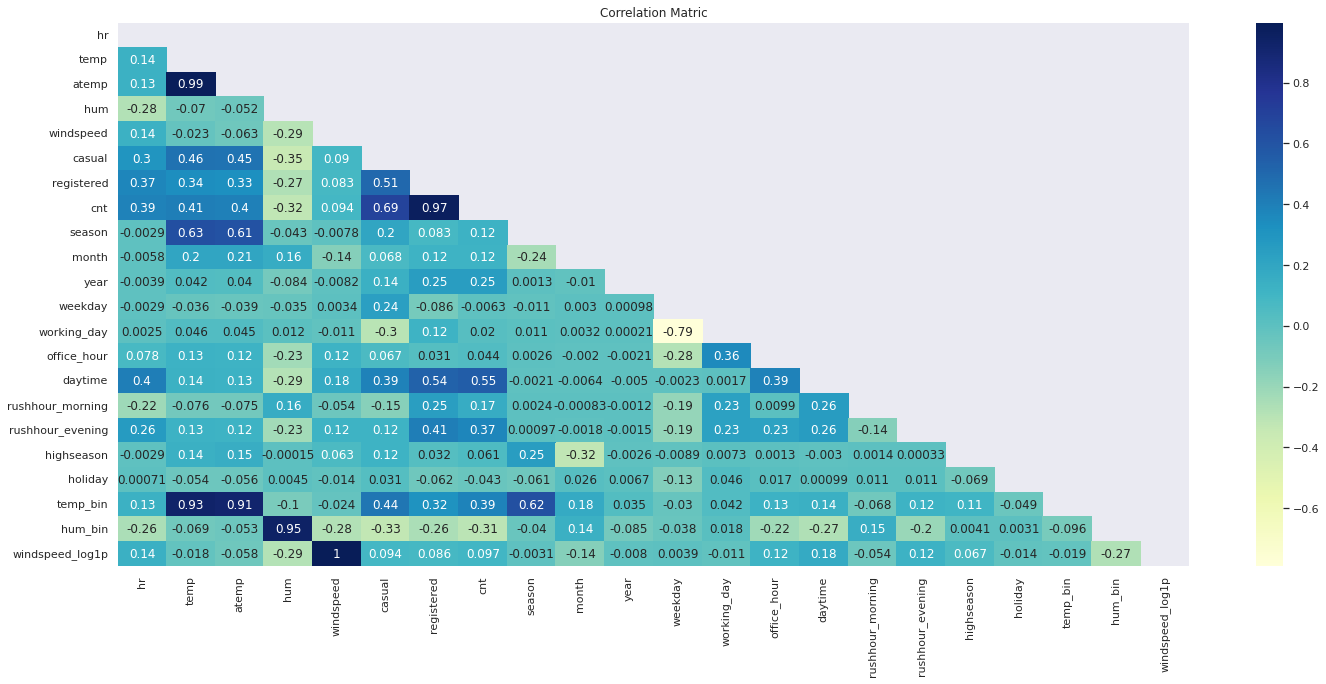

In [38]:
plt.figure(figsize = (24,10))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu", mask=matrix)
plt.title("Correlation Matric")
plt.show()

## 💡 From the correlation matrix

1. we will drop `temp` in the pipeline because it is highly correlated with `atemp`
2. Drop `casual` and `registered` due to data leakage with our target varible `cnt`
3. we also can find out like `temp bin` and `hum bin` has highly correlated with `temp` and `hum`，because it create bin from this two columns, we will futther used it in our pipeline and take trails on it

## Data Visualization

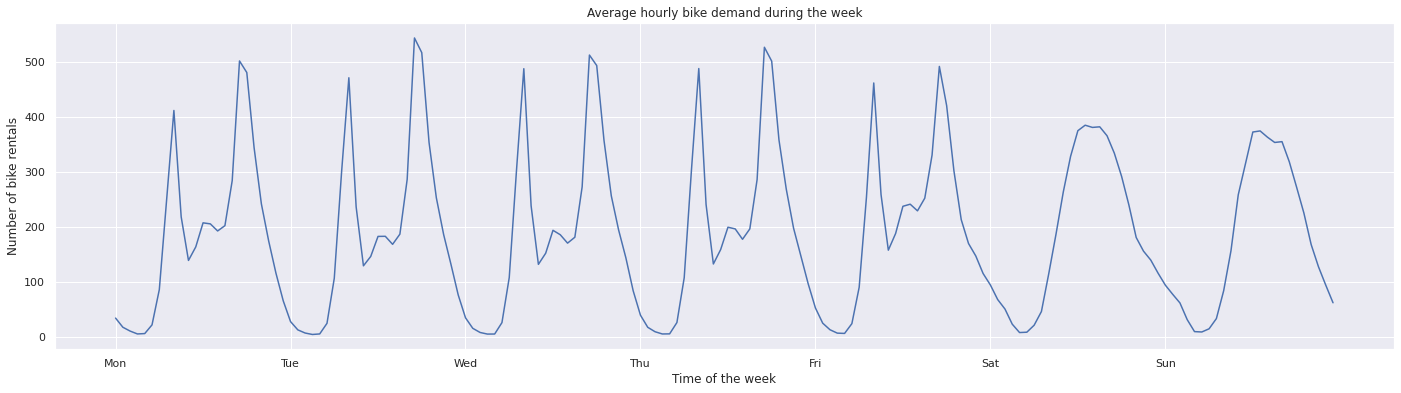

In [40]:
fig, ax = plt.subplots(figsize=(24, 6))
average_week_demand = df.groupby(["weekday", "hr"]).mean()["cnt"]
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat","Sun"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)
plt.savefig('Average hourly bike demand during week.png')


💡 **From Average Hourly Bike demand during the week graph**
* we can see that during the weekday, it usually has two peak in bike demand.


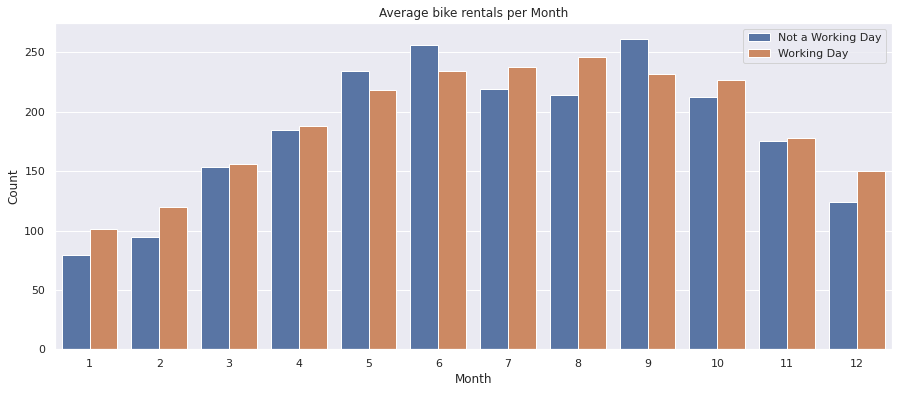

In [42]:
# Average Monthly Count Distribution plot
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
group_month = pd.DataFrame(df.groupby(['month', 'working_day'])['cnt'].mean()).reset_index()
sns.barplot(data=group_month, x='month', y='cnt', hue='working_day', ax=axes)
axes.set(xlabel='Month', ylabel='Count', title='Average bike rentals per Month')
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Working Day', 'Working Day'])
plt.show()

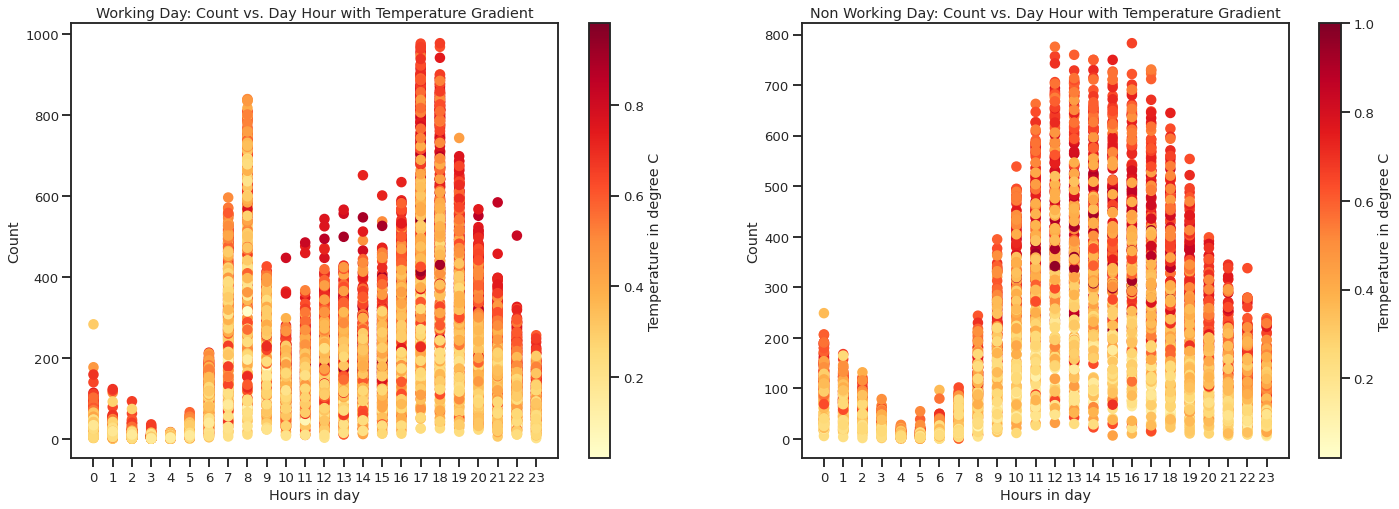

In [79]:
mydata_w = df.loc[df.working_day==1]
mydata_nw = df.loc[df.working_day==0]

fig = plt.figure(figsize=(24, 8))

# Working Day
axes = fig.add_subplot(1, 2, 1)
f = axes.scatter(mydata_w.hr, mydata_w['cnt'], c=mydata_w.temp, cmap = 'YlOrRd')
axes.set(xticks = range(24), xlabel='Hours in day', ylabel='Count', title='Working Day: Count vs. Day Hour with Temperature Gradient')
cbar = plt.colorbar(f)
cbar.set_label('Temperature in degree C')

# Non Working Day
axes = fig.add_subplot(1, 2, 2)
f = axes.scatter(mydata_nw.hr, mydata_nw['cnt'], c=mydata_nw.temp, cmap = 'YlOrRd')
axes.set(xticks = range(24), xlabel='Hours in day', ylabel='Count', title='Non Working Day: Count vs. Day Hour with Temperature Gradient')
cbar = plt.colorbar(f)
cbar.set_label('Temperature in degree C')


plt.savefig('work_not_working.png')
plt.show();

💡 **From the above plot we can see the 2 patterns across the hours in a day in bike rentals**

* **Working Day**: First pattern where there is a peak in the rentals at around 8am and another at around 5pm. These correspond to working local bikers who typically are registered and go to work on working day which are Monday to Friday
* **Non Working Day**: Second pattern where there is more or less a uniform rentals across the day with a peak at around noon time. These correspond to probably tourists who typically are casual users who rent/drop off bikes uniformly during the day and tour the city of Washington on non working days which typically are Saturday and Sunday
* From the above, we can see that in general, more people tend to prefer biking at moderate to high temperatures; however, if the temperature is too hot (darkest of the red dots), there is a small decline in count



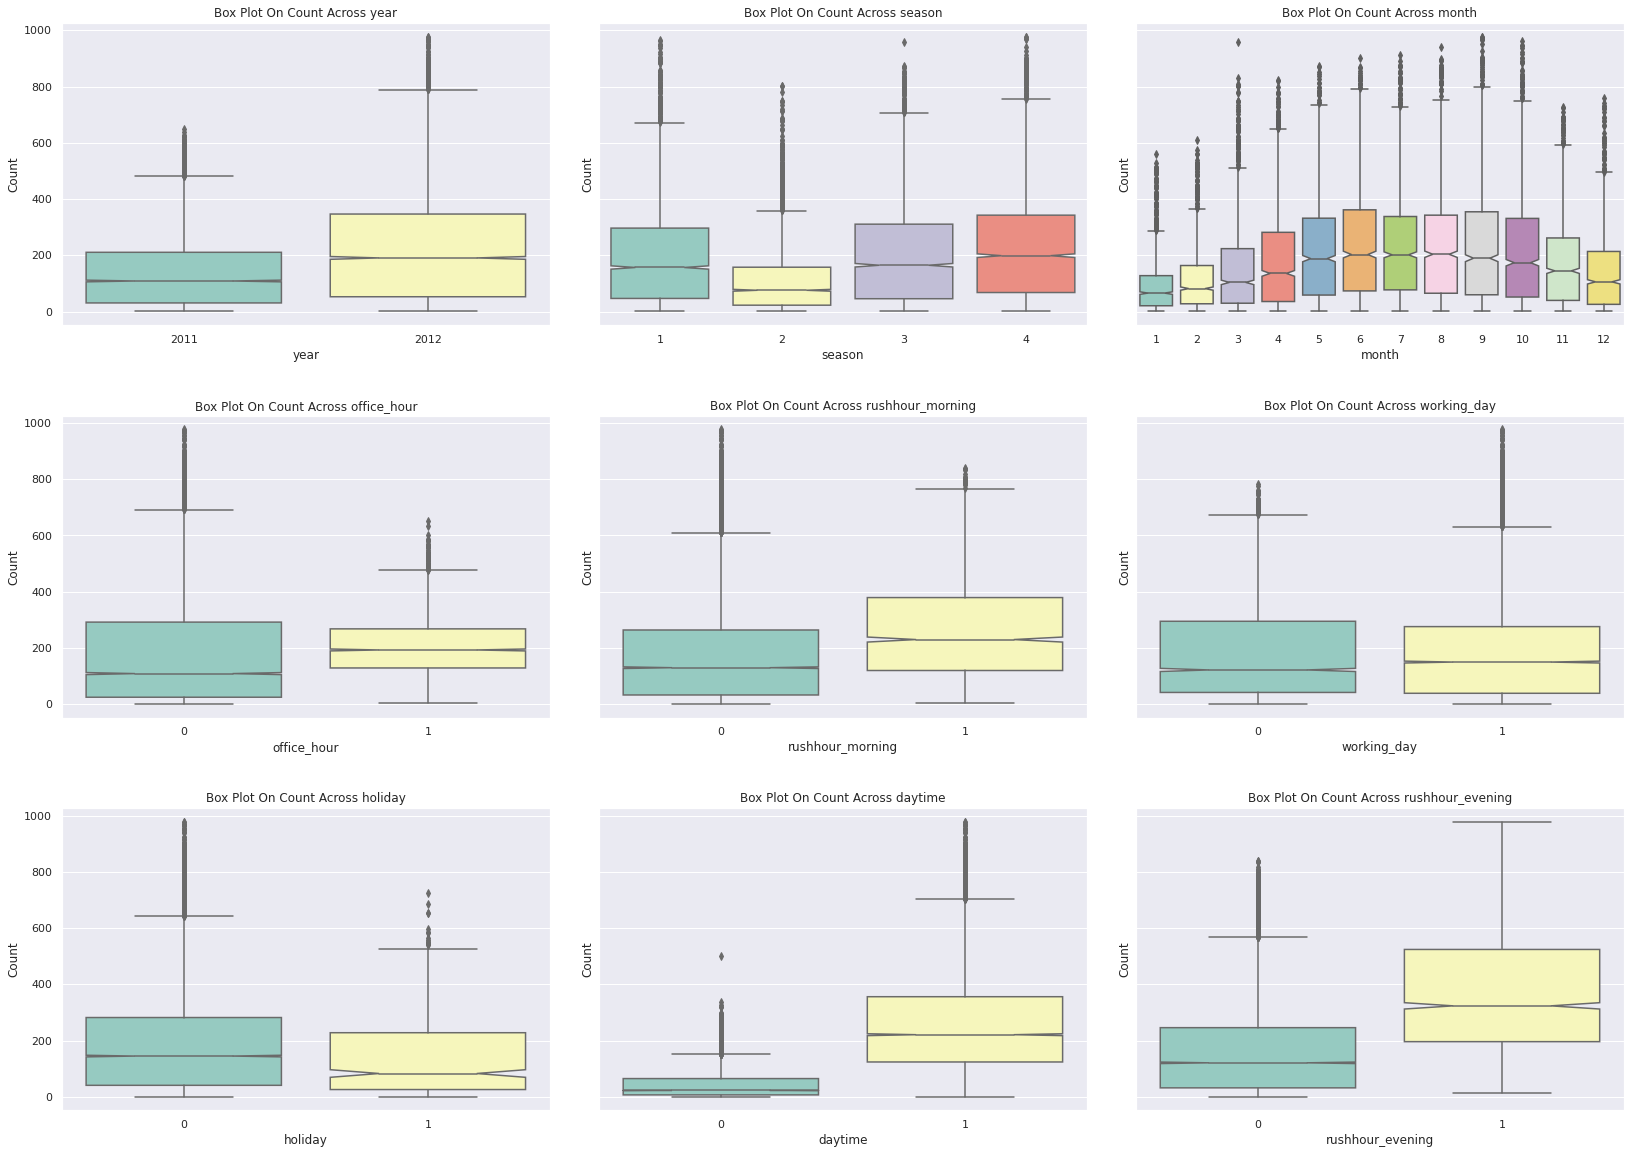

In [45]:
sns.set()
fig, axes = plt.subplots(nrows=3,ncols=3, sharey=True, figsize=(28,20))
fig.subplots_adjust(hspace=0.3, wspace=0.10)

cols = ['year','season','month','office_hour','rushhour_morning','working_day','holiday','daytime','rushhour_evening']

for i,ax in enumerate(axes.ravel()):
    sns.boxplot(y="cnt",x=cols[i], data=df, orient="v", notch=True, ax=ax,palette="Set3")
    ax.set(xlabel=cols[i], ylabel='Count', title=f"Box Plot On Count Across {cols[i]}")
fig.savefig('boxplot.png')


 # 💡 **Insights from time and bike rental demand**
   *  **Year**: 2012 has more bike rental than 2011
   *  **Season**:  Summer and Autumn has more bike rentals, we also can see it through month box plot
   > Season (1:Spring, 2:Summer, 3:Autumn, 4:Winter)
   *  From bottom middle graph, in the weekday during 6am-10am (`rushhour morning), the demand for bike rental is higher.
   *  The middle-right box plot shows people ride less on holidays. However, this plot also reveals the increase in the popularity of bicycle rentals throughout the years.
 


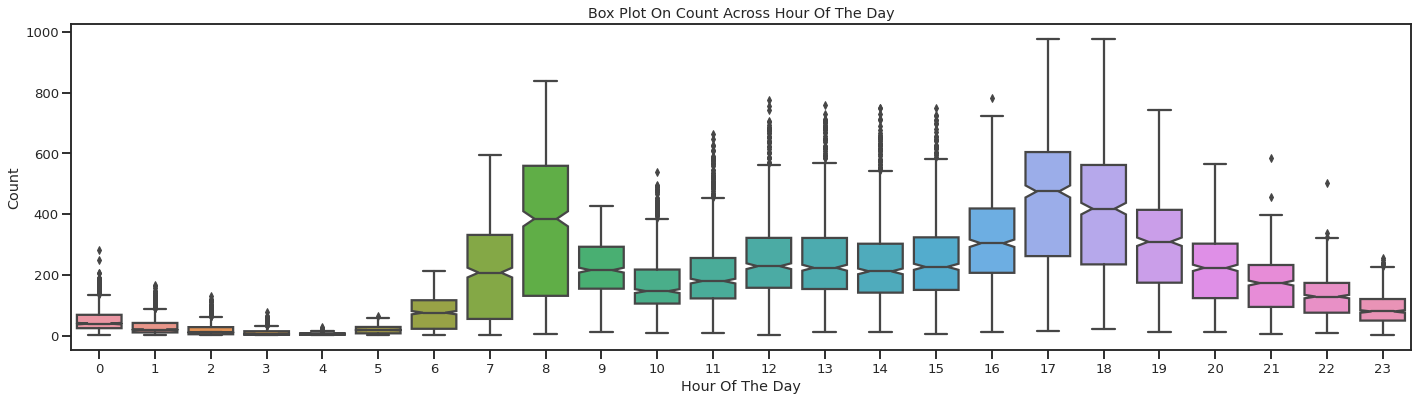

In [80]:
sns.set(context='talk',style='ticks',font_scale=0.8)
fig, axes = plt.subplots(nrows=1,ncols=1, sharey=True, figsize=(24,6))
sns.boxplot(y="cnt",x="hr", data=df, orient="v", notch=True, ax=axes)
axes.set(xlabel='Hour Of The Day', ylabel='Count', title="Box Plot On Count Across Hour Of The Day")

plt.savefig('Box Plot per Hour.png')
plt.show()
plt.close('all')

### 💡 **Insight**
  * The box plot resembles both the increase in popularity and cyclical behavior. This time with two cycles over a short period of time, a day. The demand for bicycles picks between 7–9 AM and 5–6 PM. These patterns match workers going to work and leaving work; workers actually use bicycles as transportation media for work. 
  * Notice demand remains relatively constant between peak hours, this could be explained by “regular people”, tourists, and students using bicycles.

<Figure size 432x288 with 0 Axes>

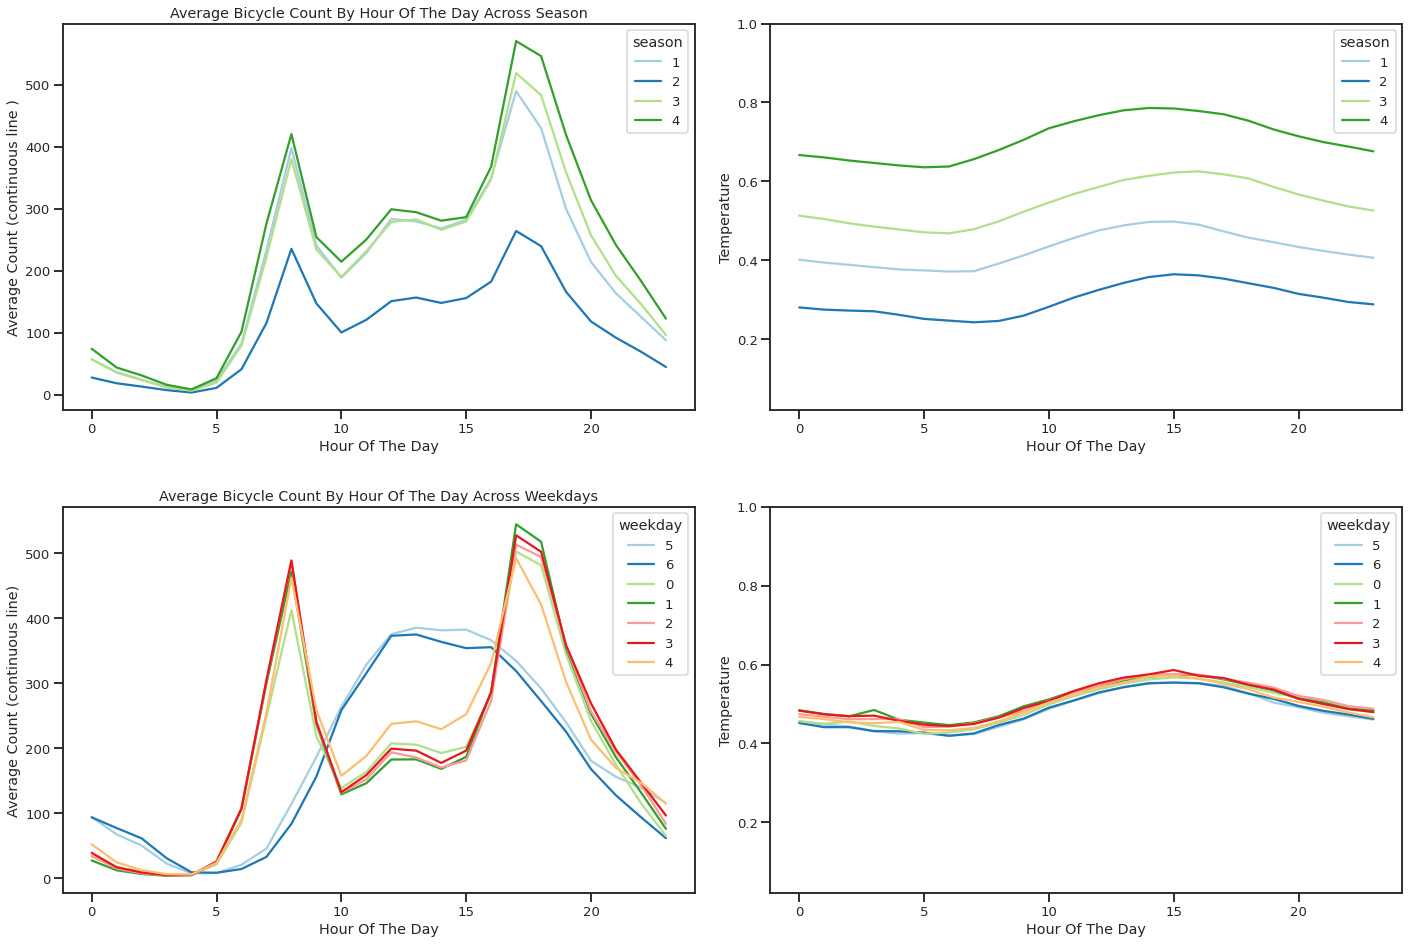

In [81]:
fig = plt.figure()
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(24,16))
fig.subplots_adjust(hspace=0.25, wspace=0.12)


seasonOrder  = [1,2,3,4]
WeekdayOrder = [5, 6, 0, 1, 2, 3, 4]

# 1.Season (1:Spring, 2:Summer, 3:Autumn, 4:Winter)
ax1 = sns.lineplot(x="hr", y="cnt",hue="season",  hue_order=seasonOrder, data=df,palette='Paired', ax=axes[0][0],ci=None)
#xticklabels=["Spring", "Summer", "Autumn", "Winter"],
ax1.set(xlabel='Hour Of The Day', ylabel='Average Count (continuous line )', title ="Average Bicycle Count By Hour Of The Day Across Season", label='big')

#ax1a = ax1.twinx()
ax1a = sns.lineplot(x="hr", y="temp", hue="season", hue_order=seasonOrder, data=df,palette='Paired',ax=axes[0][1],ci=None)
ax1a.set(xlabel='Hour Of The Day',ylabel='Temperature', label='big', ylim=(df.temp.min(),df.temp.max())) 


ax2 = sns.lineplot(x="hr", y="cnt", hue="weekday", hue_order=WeekdayOrder, data=df,palette='Paired',ax=axes[1][0],ci=None)
ax2.set(xlabel='Hour Of The Day', ylabel='Average Count (continuous line)',title="Average Bicycle Count By Hour Of The Day Across Weekdays",label='big')
        
#ax2a = ax2.twinx()
ax2a = sns.lineplot(x="hr", y="temp", hue="weekday", hue_order=WeekdayOrder, data=df,palette='Paired',ax=axes[1][1],ci=None)
ax2a.set(xlabel='Hour Of The Day',ylabel='Temperature', label='big', ylim=(df.temp.min(),df.temp.max()))


plt.savefig('Seasons.png')
plt.show()
plt.close('all')

# 💡Insight
* **Season**:Autumn(Season 3 in the graph) shows the highest average temperatures throughout the day; in contrast, Spring shows the lowest average temperature throughout the day. These lowest average temperatures in Spring seem to correlate with the lowest average bike count, which also happens in Spring.
> Season (1:Spring, 2:Summer, 3:Autumn, 4:Winter)
* The second plot also reveals an interesting trend. The average temperature remains constant throughout the days of the week. And also the average demand for bicycles is higher during the weekends, especially late morning and early afternoon.


In [ ]:
fig = plt.figure(figsize=(24, 8))
axes = fig.add_subplot(1, 3, 1)
sns.regplot(data=df, x='temp', y='cnt',ax=axes,line_kws={"color": "black"})
axes.set(title='Reg Plot for Temperature vs. Count')
axes = fig.add_subplot(1, 3, 2)
sns.regplot(data=df, x='hum', y='cnt',ax=axes, color='r',line_kws={"color": "black"})
axes.set(title='Reg Plot for Humidity vs. Count')
axes = fig.add_subplot(1, 3, 3)
sns.regplot(data=df, x='windspeed', y='cnt',ax=axes, color='g',line_kws={"color": "black"})
axes.set(title='Reg Plot for Windspeed vs. Count') #why do we not use log windspeed

plt.savefig('regplot.png')
plt.show()

# 💡 **Insights**
* The above regplot indicates a positive correlation of count with temperature and windspeed and a negative correlation with humidity

# <a id='3.4'></a>
# 3.4 🚲 **Pipeline---Time-Based cross validation**
**Time Based Cross-validation**
- Since the dataset is a time-ordered event log (hourly demand), we will use a time-sensitive cross-validation splitter to evaluate our demand forecasting model as realistically as possible. 
- We use a gap of 2 days between the train and test side of the splits. We also limit the training set size to make the performance of the CV folds more stable.
- 1000 test datapoints should be enough to quantify the performance of the model. This represents a bit less than a month and a half of contiguous test data

In [49]:
df.dtypes

dteday              datetime64[ns]
hr                           int64
weathersit                  object
temp                       float64
atemp                      float64
hum                        float64
windspeed                  float64
casual                       int64
registered                   int64
cnt                          int64
season                       int64
month                        int64
year                         int64
weekday                      int64
working_day                  int64
office_hour                  int64
daytime                      int64
rushhour_morning             int64
rushhour_evening             int64
highseason                   int64
holiday                      int64
temp_bin                      int8
hum_bin                       int8
windspeed_log1p            float64
dtype: object

In [50]:
#divide to train and test
train = df.loc[(df["dteday"].isin(pd.date_range(start = "01/01/2011", end = "30/09/2012")))==True]
test = df.loc[(df["dteday"].isin(pd.date_range(start = "01/01/2011", end = "30/09/2012")))==False] # year 2012 4th quarter

#create 'X_train', 'y_train', 'X_test', and 'y_test'
X_train = train.drop("cnt", axis="columns")
y_train = train['cnt']

X_test = test.drop("cnt", axis="columns")
y_test = test['cnt']

In [51]:
df.shape

(17379, 24)

In [52]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

Let us manually inspect the various splits to check that the TimeSeriesSplit works as we expect, starting with the first split:

In [53]:
all_splits = list(ts_cv.split(X_train, y_train))
train_0, test_0 = all_splits[0]

In [54]:
X_train.iloc[test_0].head(3)

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,season,...,working_day,office_hour,daytime,rushhour_morning,rushhour_evening,highseason,holiday,temp_bin,hum_bin,windspeed_log1p
instant,,,,,,,,,,,,,,,,,,,,,
10212,2012-03-06,13,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.30,0.303,0.39,0.1343,16,148,2,...,1,1,1,0,0,0,0,1,1,0.126016
10213,2012-03-06,14,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.32,0.303,0.36,0.2239,20,116,2,...,1,1,1,0,0,0,0,1,1,0.202042
10214,2012-03-06,15,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.34,0.303,0.36,0.2985,24,142,2,...,1,1,1,0,1,0,0,1,1,0.261210


In [55]:
X_train.iloc[test_0].shape

(1000, 23)

In [56]:
X_train.iloc[train_0].head(3)

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,season,...,working_day,office_hour,daytime,rushhour_morning,rushhour_evening,highseason,holiday,temp_bin,hum_bin,windspeed_log1p
instant,,,,,,,,,,,,,,,,,,,,,
164,2011-01-08,2,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.18,0.2424,0.55,0.0000,3,13,2,...,0,0,0,0,0,0,0,0,2,0.000000
165,2011-01-08,3,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.18,0.1970,0.55,0.1642,0,7,2,...,0,0,0,0,0,0,0,0,2,0.152034
166,2011-01-08,4,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.18,0.1970,0.55,0.1642,0,1,2,...,0,0,0,0,0,0,0,0,2,0.152034


In [57]:
X_train.iloc[train_0].shape

(10000, 23)

<a id='3.5'></a>
# 3.5 🚲 Pipeline--- Deal with Missing Value & outlier
* As mentioned before, we will drop `casual`,`registered` (due to data leakage) and `atemp (highly correlated with `temp`) 
* We also drop `dteday` because we already generate lots of feature related to time and to avoid weight more on variable of time, we need to drop it
* Numerical column `hum`and `windspeed` , we use median to replace it. Median will be more robust compare with imputing mean
* `temp` we use KNN imputer, due to the the nature of tempeture, we choose the KNN imputer to impute it
* for Text column, we will use the most frequent values to impute it

In [58]:
df.isna().sum() # now, we are going to deal with the null value

dteday                0
hr                    0
weathersit          100
temp                 99
atemp               100
hum                 100
windspeed           100
casual                0
registered            0
cnt                   0
season                0
month                 0
year                  0
weekday               0
working_day           0
office_hour           0
daytime               0
rushhour_morning      0
rushhour_evening      0
highseason            0
holiday               0
temp_bin              0
hum_bin               0
windspeed_log1p       0
dtype: int64

## **Create multiple transformers**

### **Transformer 1 -- all time features as numerical values**

In [59]:
df.dtypes

dteday              datetime64[ns]
hr                           int64
weathersit                  object
temp                       float64
atemp                      float64
hum                        float64
windspeed                  float64
casual                       int64
registered                   int64
cnt                          int64
season                       int64
month                        int64
year                         int64
weekday                      int64
working_day                  int64
office_hour                  int64
daytime                      int64
rushhour_morning             int64
rushhour_evening             int64
highseason                   int64
holiday                      int64
temp_bin                      int8
hum_bin                       int8
windspeed_log1p            float64
dtype: object

In [60]:
sklearn.set_config(display='diagram')

transformer = make_column_transformer(
    ("drop", ["atemp",'dteday','casual','registered']),
    (KNNImputer(n_neighbors=2), ["temp"]), 
    (SimpleImputer(strategy="median"), ["hum"]),
    (SimpleImputer(strategy="median"), ["windspeed"]),
    (make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore')),["weathersit"]),
    remainder = MinMaxScaler()
    
)
transformer

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('drop', 'drop',
                                 ['atemp', 'dteday', 'casual', 'registered']),
                                ('knnimputer', KNNImputer(n_neighbors=2),
                                 ['temp']),
                                ('simpleimputer-1',
                                 SimpleImputer(strategy='median'), ['hum']),
                                ('simpleimputer-2',
                                 SimpleImputer(strategy='median'),
                                 ['windspeed']),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['weathersit'])])

### **Transformer 2 -- One hot encode all time related features**

In [61]:
time_related_features = [
    'season', 'month', 'year', 'weekday','working_day', 'office_hour', 'daytime',
    'rushhour_morning','rushhour_evening', 'highseason', 'holiday','hr'
]

one_hot_transformer = make_column_transformer(
    ("drop", ["atemp",'dteday','casual','registered']),
    (KNNImputer(n_neighbors=2), ["temp"]), 
    (SimpleImputer(strategy="median"), ["hum"]),
    (SimpleImputer(strategy="median"), ["windspeed"]),
    (make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore')),["weathersit"]),
    (OneHotEncoder(handle_unknown='ignore'), time_related_features),
    remainder = MinMaxScaler()
    
)

one_hot_transformer

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('drop', 'drop',
                                 ['atemp', 'dteday', 'casual', 'registered']),
                                ('knnimputer', KNNImputer(n_neighbors=2),
                                 ['temp']),
                                ('simpleimputer-1',
                                 SimpleImputer(strategy='median'), ['hum']),
                                ('simpleimputer-2',
                                 SimpleImputer(strategy='median'),
                                 ['windspeed']),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['weathersit']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['season', 'month', 'year', 'weekday',
                                  'working_day', 'office_hour', 'daytime',
                                  'rushhour_morning', 'rushhour_evening',
                                  'highseason', 'holiday', 'hr'])])

### **Transformer 3 -- Create trigonometric features to capture cyclic events**
* try to encode each of those periodic features(`month`,`weekday` and `hr`) using a sine and cosine transformation with the matching period.
* encode equivalent information in a non-monotonic way, and more importantly without any jump between the first and the last value of the periodic range.
* this helps us to capture seasonity in `month`,`weekday` and `hr`

In [62]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

cyclic_transformer = make_column_transformer(
        ("drop", ["atemp",'dteday','casual','registered']),
        (KNNImputer(n_neighbors=2), ["temp"]), 
        (SimpleImputer(strategy="median"), ["hum"]),
        (SimpleImputer(strategy="median"), ["windspeed"]),
        (make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore')),["weathersit"]),
        (sin_transformer(12), ["month"]),
        (cos_transformer(12), ["month"]),
        (sin_transformer(7), ["weekday"]),
        (cos_transformer(7), ["weekday"]),
        (sin_transformer(24), ["hr"]),
        (cos_transformer(24), ["hr"]),
        remainder=MinMaxScaler(),
)
cyclic_transformer

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('drop', 'drop',
                                 ['atemp', 'dteday', 'casual', 'registered']),
                                ('knnimputer', KNNImputer(n_neighbors=2),
                                 ['temp']),
                                ('simpleimputer-1',
                                 SimpleImputer(strategy='median'), ['hum']),
                                ('simpleimputer-2',
                                 SimpleImputer(strategy='median'),
                                 ['windspeed']),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer...
                                ('functiontransformer-4',
                                 FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x7f6f808e7550>),
                                 ['weekday']),
                                ('functiontransformer-5',
                                 FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x7f6f808e75e0>),
                                 ['hr']),
                                ('functiontransformer-6',
                                 FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x7f6f808e7670>),
                                 ['hr'])])

<a id='4'></a>
# 4. Machine Learning (predictive analytics) (3 points)
* Choosing sensible models (linear and non-linear).
* Tuning model parameters with validation (use the fixed validation set).
* Obtaining accurate predictions in test (measured with R2 score).
* Plotting predictions vs. reality for additional insights.
>
>Bonus points for:
>
>* Plotting validation results to justify further choices (parameter ranges, other validations...).
>* Following an incremental approach (baseline models first, then more complex models, then combining models...)

<a id='4.1'></a>
## 🚲 4.1 1st Model---Baseline Model(Linear Regression)

In [63]:
# creating the pipeline with transformer 1
ct = Pipeline([
    ('transformer', transformer),
    ('model',LinearRegression())
])
ct

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('drop', 'drop',
                                                  ['atemp', 'dteday', 'casual',
                                                   'registered']),
                                                 ('knnimputer',
                                                  KNNImputer(n_neighbors=2),
                                                  ['temp']),
                                                 ('simpleimputer-1',
                                                  SimpleImputer(strategy='median'),
                                                  ['hum']),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(strategy='median'),
                                                  ['windspeed']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['weathersit'])])),
                ('model', LinearRegression())])

In [64]:
from sklearn.model_selection import cross_val_score

In [65]:
#R2 - coefficient of determination, best would be 1
lr_score = cross_val_score(ct,X_train,y_train,scoring='r2',cv=ts_cv)
lr_score

array([0.53376524, 0.61451853, 0.61362719, 0.64655733, 0.59367298])

In [66]:
lr_score.mean()

0.6004282529762912

#### **Time-steps as categories**
> we add OneHotEncoder for the categroical varibale

In [67]:
#create a pipeline with one_hot_transformer
ct_cat = Pipeline([
    ('transformer', one_hot_transformer),
    ('model',LinearRegression())
])
ct_cat

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('drop', 'drop',
                                                  ['atemp', 'dteday', 'casual',
                                                   'registered']),
                                                 ('knnimputer',
                                                  KNNImputer(n_neighbors=2),
                                                  ['temp']),
                                                 ('simpleimputer-1',
                                                  SimpleImputer(strategy='median'),
                                                  ['hum']),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(strategy='median'),
                                                  ['windspeed']),
                                                 ('pipeline',
                                                  Pipeline(steps=...er',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['weathersit']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season', 'month', 'year',
                                                   'weekday', 'working_day',
                                                   'office_hour', 'daytime',
                                                   'rushhour_morning',
                                                   'rushhour_evening',
                                                   'highseason', 'holiday',
                                                   'hr'])])),
                ('model', LinearRegression())])

In [68]:
lr2_score = cross_val_score(ct_cat,X_train,y_train,scoring='r2',cv=ts_cv)
lr2_score

array([0.6733645 , 0.75398954, 0.76071628, 0.77953314, 0.78351997])

In [69]:
lr2_score.mean()

0.7502246867366512

#### **Cylic features**
periodic feature engineering strategy.

In [70]:
#create a pipeline with cyclic transformer
ct_cyc = Pipeline([
    ('transformer', cyclic_transformer),
    ('model',LinearRegression())
])
ct_cyc

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('drop', 'drop',
                                                  ['atemp', 'dteday', 'casual',
                                                   'registered']),
                                                 ('knnimputer',
                                                  KNNImputer(n_neighbors=2),
                                                  ['temp']),
                                                 ('simpleimputer-1',
                                                  SimpleImputer(strategy='median'),
                                                  ['hum']),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(strategy='median'),
                                                  ['windspeed']),
                                                 ('pipeline',
                                                  Pipeline(steps=...
                                                  FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x7f6f808e7550>),
                                                  ['weekday']),
                                                 ('functiontransformer-5',
                                                  FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x7f6f808e75e0>),
                                                  ['hr']),
                                                 ('functiontransformer-6',
                                                  FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x7f6f808e7670>),
                                                  ['hr'])])),
                ('model', LinearRegression())])

In [71]:
lr3_score = cross_val_score(ct_cyc,X_train,y_train,scoring='r2',cv=ts_cv)
lr3_score

array([0.61381674, 0.72181266, 0.71644298, 0.71939599, 0.70703736])

In [72]:
lr3_score.mean()

0.6957011472823138

<a id='4.2'></a>
## 🚲 4.2 2nd Model---Random Forest 

In [73]:
ct2 = Pipeline([
    ('transformer', transformer),
    ('model',RandomForestRegressor())
])


In [74]:
rf_score = cross_val_score(ct2,X_train,y_train,scoring='r2',cv=ts_cv)
rf_score

array([0.73400385, 0.87916166, 0.87624632, 0.90935995, 0.92148215])

In [75]:
rf_score.mean()

0.8640507857714985

#### Time-steps as categories

In [76]:
ct2_cat = Pipeline([
    ('transformer', one_hot_transformer),
    ('model',RandomForestRegressor())
])

In [77]:
rf_score2 = cross_val_score(ct2_cat,X_train,y_train,scoring='r2',cv=ts_cv)
rf_score2

KeyboardInterrupt: ignored

In [ ]:
rf_score2.mean()

#### Cyclic Features

In [ ]:
ct2_cyc = Pipeline([
    ('transformer', cyclic_transformer),
    ('model',RandomForestRegressor())
])

In [ ]:
rf_score3 = cross_val_score(ct2_cyc,X_train,y_train,scoring='r2',cv=ts_cv)
rf_score3

In [ ]:
rf_score3.mean()

<a id='4.3'></a>
## 🚲 4.3 3rd Model---Decision Tree 

In [ ]:

ct3 = Pipeline([
    ('transformer', transformer),
    ('model',)
])DecisionTreeRegressor()


In [ ]:
dt_score = cross_val_score(ct3,X_train,y_train,scoring='r2',cv=ts_cv)
dt_score

In [ ]:
dt_score.mean()

##### **Time-steps as categories**

In [ ]:
ct3_cat = Pipeline([
    ('transformer', one_hot_transformer),
    ('model',DecisionTreeRegressor())
])

In [ ]:
dt_score2 = cross_val_score(ct3_cat,X_train,y_train,scoring='r2',cv=ts_cv)
dt_score2

In [ ]:
dt_score2.mean()

#### **Cyclic Features**

In [ ]:
ct3_cyc = Pipeline([
    ('transformer', cyclic_transformer),
    ('model',DecisionTreeRegressor())
])

In [ ]:
dt_score3 = cross_val_score(ct3_cyc,X_train,y_train,scoring='r2',cv=ts_cv)
dt_score3

In [ ]:
dt_score3.mean()

<a id='4.4'></a>
## 4.4 Grid Search best Parameters
* By using grid search cv find the parameters that give higher score

> [4.4.1 Pipeline 1](#4.4.1)
>
> [4.4.2 Pipeline 2](#4.4.2)
>
> [4.4.3 Pipeline 3](#4.4.3)


In [ ]:
#create three different pipelines based on different transformers
clf = Pipeline([
    ('transformer', transformer),
    ('model',LinearRegression())
])

clf2 = Pipeline([
    ('transformer', one_hot_transformer),
    ('model',LinearRegression())
])

clf3 = Pipeline([
    ('transformer', cyclic_transformer),
    ('model',LinearRegression())
])

In [ ]:
clf

In [ ]:
param_grid = [
    {
        "transformer__knnimputer__n_neighbors": range(2, 6),
        "transformer__simpleimputer-1__strategy": ["mean",'median'],
        "transformer__simpleimputer-2__strategy": ["mean",'median'],
        "model": [LinearRegression()],
        "model__normalize": [False,True], 
    },
    {
        "transformer__knnimputer__n_neighbors": range(2, 6),
        "transformer__simpleimputer-1__strategy": ["mean",'median'],
        "transformer__simpleimputer-2__strategy": ["mean",'median'],
        "model": [DecisionTreeRegressor()], 
        "model__splitter":['best','random'],
        "model__max_depth": [1,5,9,12],
        "model__min_samples_leaf":[1,3,6,7],
        "model__min_weight_fraction_leaf":[0.1,0.3,0.4],
        "model__max_features":["auto","sqrt",None],
        "model__max_leaf_nodes":[None,10,30,60],
        "model__random_state": [42],
    },
    {
        "transformer__knnimputer__n_neighbors": range(2, 6),
        "transformer__simpleimputer-1__strategy": ["mean",'median'],
        "transformer__simpleimputer-2__strategy": ["mean",'median'],
        "model": [RandomForestRegressor()],
        "model__random_state": [42],
        "model__max_depth": [3,6,7,10],
        "model__n_estimators": [30, 40, 70, 100],
        "model__max_features": ["auto","sqrt"],
        "model__min_samples_leaf": [1, 2, 4],
    }
]

<a id='4.4.1'></a>
### 🚲 **4.4.1 Pipeline 1**


In [ ]:
clf

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
try:
    results = pd.read_csv("grid_search_result_1.csv")
except:
    gs1 = GridSearchCV(clf, param_grid, n_jobs=-1, cv=ts_cv, scoring="r2")
    gs1.fit(X_train, y_train)

    print(gs1.best_score_)

    results = pd.DataFrame(gs1.cv_results_).sort_values("rank_test_score")
    results.to_csv("grid_search_result_1.csv")
results.head()

In [ ]:
### Plot best value for each model
results['model'] = np.where(results['param_model'].str.contains('LinearRegression'), 'LinearRegression',
                     (np.where(results['param_model'].str.contains('RandomForest'),'RandomForestRegressor','DecisionTreeRegressor')))

model_maximum = results.groupby(['model'])[['mean_test_score']].max().reset_index()
model_maximum

In [ ]:
sns.barplot(x='model',y='mean_test_score',data=model_maximum)
plt.show()

### Linear Regression

In [ ]:
linear_regression_params = results.loc[results['param_model'].str.contains('LinearRegression')]
linear_regression_params = linear_regression_params[[
    'param_transformer__knnimputer__n_neighbors',
    'param_model__normalize',
    'param_transformer__simpleimputer-1__strategy',
    'param_transformer__simpleimputer-2__strategy',
    'mean_test_score'
]].rename(columns={
    "param_transformer__knnimputer__n_neighbors": "n_neighbors",
    'param_model__normalize':'normalize',
    'param_transformer__simpleimputer-1__strategy':'simpleimputer-1',
    'param_transformer__simpleimputer-2__strategy':'simpleimputer-2',
}).dropna()

In [ ]:
linear_regression_params.head(3)

In [ ]:

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(22,8))
hues = ['normalize','simpleimputer-1','simpleimputer-2']
for i,axes in enumerate(ax.ravel()):
    sns.scatterplot(x='n_neighbors',y='mean_test_score',hue=hues[i],data=linear_regression_params,ax=axes,ci=None)
plt.show()

### Random Forest

In [ ]:

rf_regression_params = results.loc[results['param_model'].str.contains('RandomForest')]
print(len(rf_regression_params))
rf_regression_params = rf_regression_params[[
    'param_transformer__knnimputer__n_neighbors',
    'param_model__splitter',
    'param_transformer__simpleimputer-1__strategy',
    'param_transformer__simpleimputer-2__strategy',
    'param_model__max_depth',
    'param_model__min_samples_leaf',
    'param_model__n_estimators',
    'param_model__max_features',
    'mean_test_score'
]].rename(columns={
    "param_transformer__knnimputer__n_neighbors": "n_neighbors",
    'param_model__splitter':'splitter',
    'param_transformer__simpleimputer-1__strategy':'simpleimputer-1',
    'param_transformer__simpleimputer-2__strategy':'simpleimputer-2',
    'param_model__max_depth':'max_depth',
    'param_model__min_samples_leaf':'min_samples_leaf',
    'param_model__n_estimators':'n_estimators',
    'param_model__max_features':'max_features',
})

In [ ]:
rf_regression_params.head(3)

In [ ]:
rf_regression_params.shape

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(22,8))

hues = ['simpleimputer-1','simpleimputer-2','max_features']
for i,axes in enumerate(ax.ravel()):
    sns.scatterplot(x='max_depth',y='mean_test_score',hue=hues[i],data=rf_regression_params,ax=axes)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(22,8))

hues = ['simpleimputer-1','simpleimputer-2','max_features']
for i,axes in enumerate(ax.ravel()):
    sns.scatterplot(x='n_estimators',y='mean_test_score',hue=hues[i],data=rf_regression_params,ax=axes,ci=None)
plt.show()

<a id='4.4.2'></a>
### 🚲 4.4.2 Pipeline 2



In [ ]:
clf2

In [ ]:
try:
    results2 = pd.read_csv("grid_search_result_2.csv")
except:
    gs2 = GridSearchCV(clf2, param_grid, n_jobs=-1, cv=ts_cv, scoring="r2")
    gs2.fit(X_train, y_train)

    print(gs2.best_score_)

    results2 = pd.DataFrame(gs2.cv_results_).sort_values("rank_test_score")
    results2.to_csv("grid_search_result_2.csv")
results2.head()

In [ ]:
### Plot best value for each model
results2['model'] = np.where(results2['param_model'].str.contains('LinearRegression'), 'LinearRegression',
                     (np.where(results2['param_model'].str.contains('RandomForest'),'RandomForestRegressor','DecisionTreeRegressor')))

model_maximum2 = results2.groupby(['model'])[['mean_test_score']].max().reset_index()
model_maximum2

In [ ]:
sns.barplot(x='model',y='mean_test_score',data=model_maximum2)
plt.show()

### Linear Regression

In [ ]:
linear_regression_params = results2.loc[results2['param_model'].str.contains('LinearRegression')]
linear_regression_params = linear_regression_params[[
    'param_transformer__knnimputer__n_neighbors',
    'param_model__normalize',
    'param_transformer__simpleimputer-1__strategy',
    'param_transformer__simpleimputer-2__strategy',
    'mean_test_score'
]].rename(columns={
    "param_transformer__knnimputer__n_neighbors": "n_neighbors",
    'param_model__normalize':'normalize',
    'param_transformer__simpleimputer-1__strategy':'simpleimputer-1',
    'param_transformer__simpleimputer-2__strategy':'simpleimputer-2',
}).dropna()

In [ ]:
linear_regression_params.head(3)

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(22,8))
hues = ['normalize','simpleimputer-1','simpleimputer-2']
for i,axes in enumerate(ax.ravel()):
    sns.scatterplot(x='n_neighbors',y='mean_test_score',hue=hues[i],data=linear_regression_params,ax=axes,ci=None)
plt.show()

### Random Forest

In [ ]:
rf_regression_params = results2.loc[results2['param_model'].str.contains('RandomForest')]
rf_regression_params = rf_regression_params[[
    'param_transformer__knnimputer__n_neighbors',
    'param_model__splitter',
    'param_transformer__simpleimputer-1__strategy',
    'param_transformer__simpleimputer-2__strategy',
    'param_model__max_depth',
    'param_model__min_samples_leaf',
    'param_model__n_estimators',
    'param_model__max_features',
    'mean_test_score'
]].rename(columns={
    "param_transformer__knnimputer__n_neighbors": "n_neighbors",
    'param_model__splitter':'splitter',
    'param_transformer__simpleimputer-1__strategy':'simpleimputer-1',
    'param_transformer__simpleimputer-2__strategy':'simpleimputer-2',
    'param_model__max_depth':'max_depth',
    'param_model__min_samples_leaf':'min_samples_leaf',
    'param_model__n_estimators':'n_estimators',
    'param_model__max_features':'max_features',
})

In [ ]:
rf_regression_params.head(3)

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(22,8))

hues = ['simpleimputer-1','simpleimputer-2','max_features']
for i,axes in enumerate(ax.ravel()):
    sns.scatterplot(x='max_depth',y='mean_test_score',hue=hues[i],data=rf_regression_params,ax=axes)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(22,8))

hues = ['simpleimputer-1','simpleimputer-2','max_features']
for i,axes in enumerate(ax.ravel()):
    sns.scatterplot(x='n_estimators',y='mean_test_score',hue=hues[i],data=rf_regression_params,ax=axes,ci=None)
plt.show()

<a id='4.4.3'></a>
### 🚲 4.4.3 Pipeline 3 


In [ ]:
clf3

In [ ]:
try:
    results3 = pd.read_csv("grid_search_result_3.csv")
except:
    gs3 = GridSearchCV(clf3, param_grid, n_jobs=-1, cv=ts_cv, scoring="r2")
    gs3.fit(X_train, y_train)

    print(gs3.best_score_)

    results3 = pd.DataFrame(gs3.cv_results_).sort_values("rank_test_score")
    results3.to_csv("grid_search_result_3.csv")
results3.head()

In [ ]:
### Plot best value for each model
results3['model'] = np.where(results3['param_model'].str.contains('LinearRegression'), 'LinearRegression',
                     (np.where(results3['param_model'].str.contains('RandomForest'),'RandomForestRegressor','DecisionTreeRegressor')))

model_maximum3 = results3.groupby(['model'])[['mean_test_score']].max().reset_index()
model_maximum3

In [ ]:
sns.barplot(x='model',y='mean_test_score',data=model_maximum3)
plt.show()

<a id='4.5'></a>
## 🚲 4.5 Plot the prediction and Actual Value

In [ ]:
# since we have our best model in pipeline one we choose our result from pipeline one
final_params = results.loc[results['rank_test_score']==1]['params'].values
print(final_params[0])


In [ ]:
#use the best transformer
final_transformer = make_column_transformer(
    ("drop", ["atemp",'dteday','casual','registered']),
    (KNNImputer(n_neighbors=5), ["temp"]), 
    (SimpleImputer(strategy="median"), ["hum"]),
    (SimpleImputer(strategy="median"), ["windspeed"]),
    (make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore')),["weathersit"]),
    remainder = MinMaxScaler()
    
)

In [ ]:
#create a final model with the best parameters
final_model = Pipeline([
    ('transformer', final_transformer),
    ('model',RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=70,random_state=42))
])

In [ ]:
final_model.fit(X_train,y_train)

In [ ]:
y_pred = final_model.predict(X_test)

In [ ]:
### the r2 score
from sklearn.metrics import r2_score
print(f'The r2 score the test data is {r2_score(y_test,y_pred)}')

In [ ]:
#plot Actual vs Predicted
sns.set()
fig, ax = plt.subplots(figsize=(24, 8))

ax.plot(y_test.values, label="actual values")
ax.plot(y_pred, label="predicted values", alpha=0.7)
ax.set_title("Actual vs Prediction", fontsize=20)
ax.legend()

plt.show()

In [ ]:
#Train Actual and Test Predicted
sns.set()
fig, ax = plt.subplots(figsize=(20, 8))

sns.lineplot(x=X_train.dteday, y=y_train.values, label="Original",ax=ax , ci=None)
sns.lineplot(x=X_test.dteday,y=y_pred, label="predicted values", alpha=0.7,ax=ax,ci=None)
ax.set_title("Train vs Test Predicted", fontsize=20)
ax.legend()

plt.show()

In [ ]:
# scatter plot
fig, ax = plt.subplots(figsize=(20, 8))
ax.scatter(y_test.values,y_test.index, color='r', label="Actual")
ax.scatter(y_pred,y_test.index, color='b', label="Predictions")
ax.set_xlabel('Count')
ax.set_ylabel('Instant')
ax.set_title('Prediction vs Actual Comparison')

plt.legend()
plt.show()